In [1]:
import numpy as np
import instrument as ins
import isochrones as iso
import galaxy as gal
from driver import Driver
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import poisson
%matplotlib inline

In [2]:
def plot_pixcmd(colors, mags, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    plt.subplot(ax)
    plt.hist2d(colors, mags, bins=150, cmap='viridis', norm=mpl.colors.LogNorm())
    plt.colorbar(label='Pixel Counts')
    return ax

In [3]:
im_scale = 512
filters = [ins.Filter.HST_F475W(1.), ins.Filter.HST_F814W(1.)]
n_filters = len(filters)

In [4]:
iso_model = iso.Isochrone_Model(filters)
gal_model = gal.Galaxy_Model(1e2, np.array([6.5, 7.5, 8.25, 8.75, 9.25, 9.75, 10.1]), np.array([0.,1.,1.,1.,1.,1.,1.]), 0., 0.)

In [5]:
driver = Driver(iso_model, gpu=False)

In [6]:
raw_mags, mags, raw_images, images = driver.simulate(gal_model, im_scale)

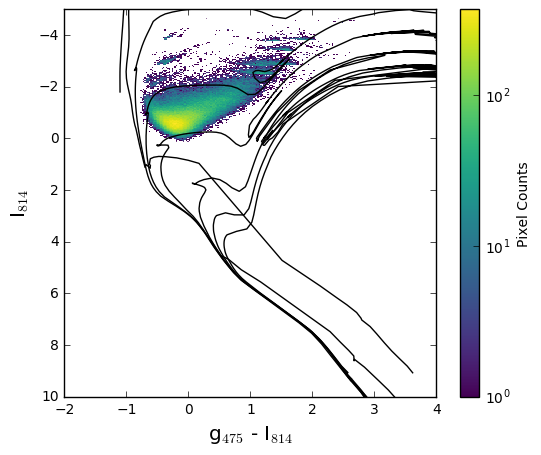

In [7]:
fig, ax = plt.subplots(figsize=(6,5))
plot_pixcmd(mags[0]-mags[1], mags[1], ax=ax)
iso_model.plot_isochrone(gal_model, ax=ax)
ax.set_ylim([10, -5])
ax.set_xlim([-2, 4])
plt.savefig('../../sandbox/2b_PSF.pdf')